# 5.2 Czym jest anomalia? Wprowadzenie do Isolation Forest
Detekcja anomalii wydaje się być na pierwszy rzut oka problemem podobnym do klasyfikacji czy klastrowania, z tą różnicą, że tutaj nie znamy docelowych etykiet i obserwacje odstające od normy nie są też najczęściej do siebie podobne. Z tego powodu nie można do tego rodzaju problemu zastosować ww. metod. Na całe szczęście algorytmy oparte o drzewa decyzyjne są na tyle elastyczne, że jesteśmy w stanie wykorzystać je również w tym przypadku.

## Dwuwymiarowy rozkład normalny

In [17]:
import numpy as np
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width

In [18]:
np.random.seed(89145)

x = np.random.normal(loc=0, size=1000)
y = np.random.normal(loc=0, size=1000)

In [19]:
import matplotlib.pyplot as plt

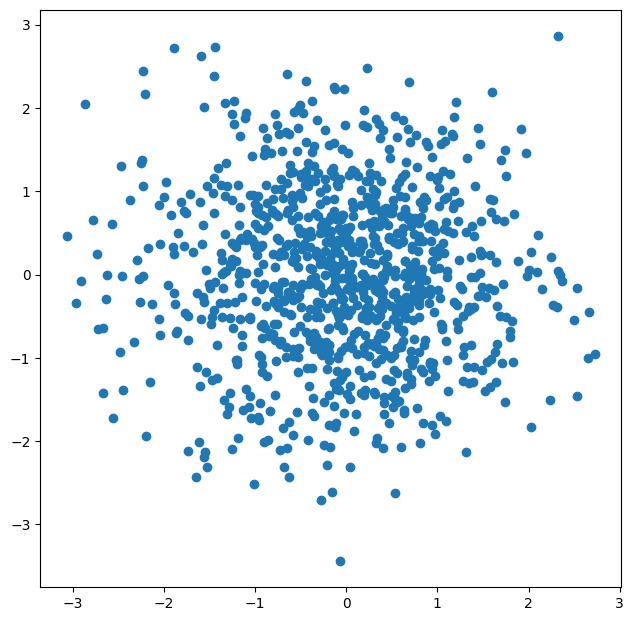

In [20]:
plt.figure(figsize=(7.5, 7.5))
plt.scatter(x, y)

Dodajemy do zbioru punkty, które w oczywisty sposób odstają od reszty.

In [21]:
x = np.append(x, [-4, -4, 4, 4])
y = np.append(y, [-3.5, 3, -3.75, 3.8])

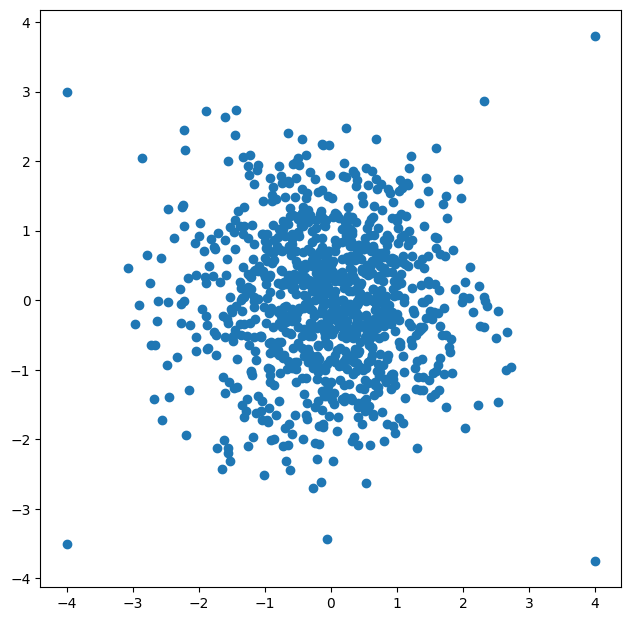

In [22]:
plt.figure(figsize=(7.5, 7.5))
plt.scatter(x, y)

In [23]:
xy_df = pd.DataFrame({"x": x, "y": y})

### Procedura stosowana w Isolation Forest
Jak wiemy, drzewa decyzyjne dzielą przestrzeń danych za pomocą pewnego rodzaju płaszczyzn, separując w każdym podziale aktualny podzbiór obserwacji na dwie części. To samo dzieje się w przypadku Isolation Forest. Tutaj podział przebiega jednak dla losowo wybranej cechy oraz losowo wybranej jej wartości z przedziału wyznaczonego przez minimalną i maksymalną wartość. Spróbujmy przeprowadzić ten proces manualnie dla naszego zbioru, ale na początek tylko dla jednego wymiaru.

In [24]:
np.random.seed(57203)

x_thresholds = np.random.uniform(xy_df["x"].min(), xy_df["x"].max(), size=15)
x_thresholds

array([-0.84414297,  2.17413738, -2.61696013, -2.05123952,  2.07046121,
       -1.69764355, -2.27401992, -2.79952929,  3.28971967,  1.4338514 ,
        3.42654469,  1.33774073, -1.51240302, -0.29747393, -2.79925695])

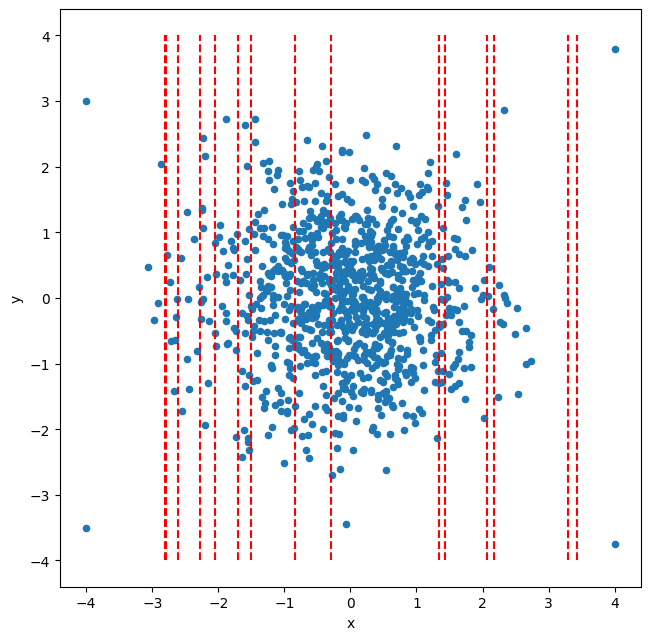

In [30]:
xy_df.plot.scatter(x="x", y="y", figsize=(7.5, 7.5))
for x_value in x_thresholds:
    plt.plot([x_value, x_value], [-4, 4], "r--")

Dzieląc przestrzeń losowymi prostymi, powinniśmy spodziewać się, że najwcześniej odseparujemy takie obserwacje, które w jakiś sposób różnią się od typowych rekordów należących do naszego zbioru. W stworzonym drzewie takie wpisy znajdą się w liściach na wyższych poziomach niż obserwacje typowe. Odległość danej obserwacji do korzenia drzewa może zostać wykorzystana jako miara normalności

Procedura ta ma dość duży element losowości, w związku z czym przeprowadza się ją wielokrotnie, aby uśrednić wyniki. Jest to podejście stosowane w metodzie Isolation Forest, która swoim działaniem może przypominać Random Forest.

### Isolation Forest w praktyce

In [31]:
from sklearn.ensemble import IsolationForest

In [32]:
iforest = IsolationForest(n_estimators=3, random_state=214)
iforest.fit(xy_df)

IsolationForest(n_estimators=3, random_state=214)

In [33]:
iforest.estimators_

[ExtraTreeRegressor(max_depth=8, max_features=1, random_state=1946395467),
 ExtraTreeRegressor(max_depth=8, max_features=1, random_state=2097488109),
 ExtraTreeRegressor(max_depth=8, max_features=1, random_state=906743342)]

In [34]:
from sklearn.tree import plot_tree

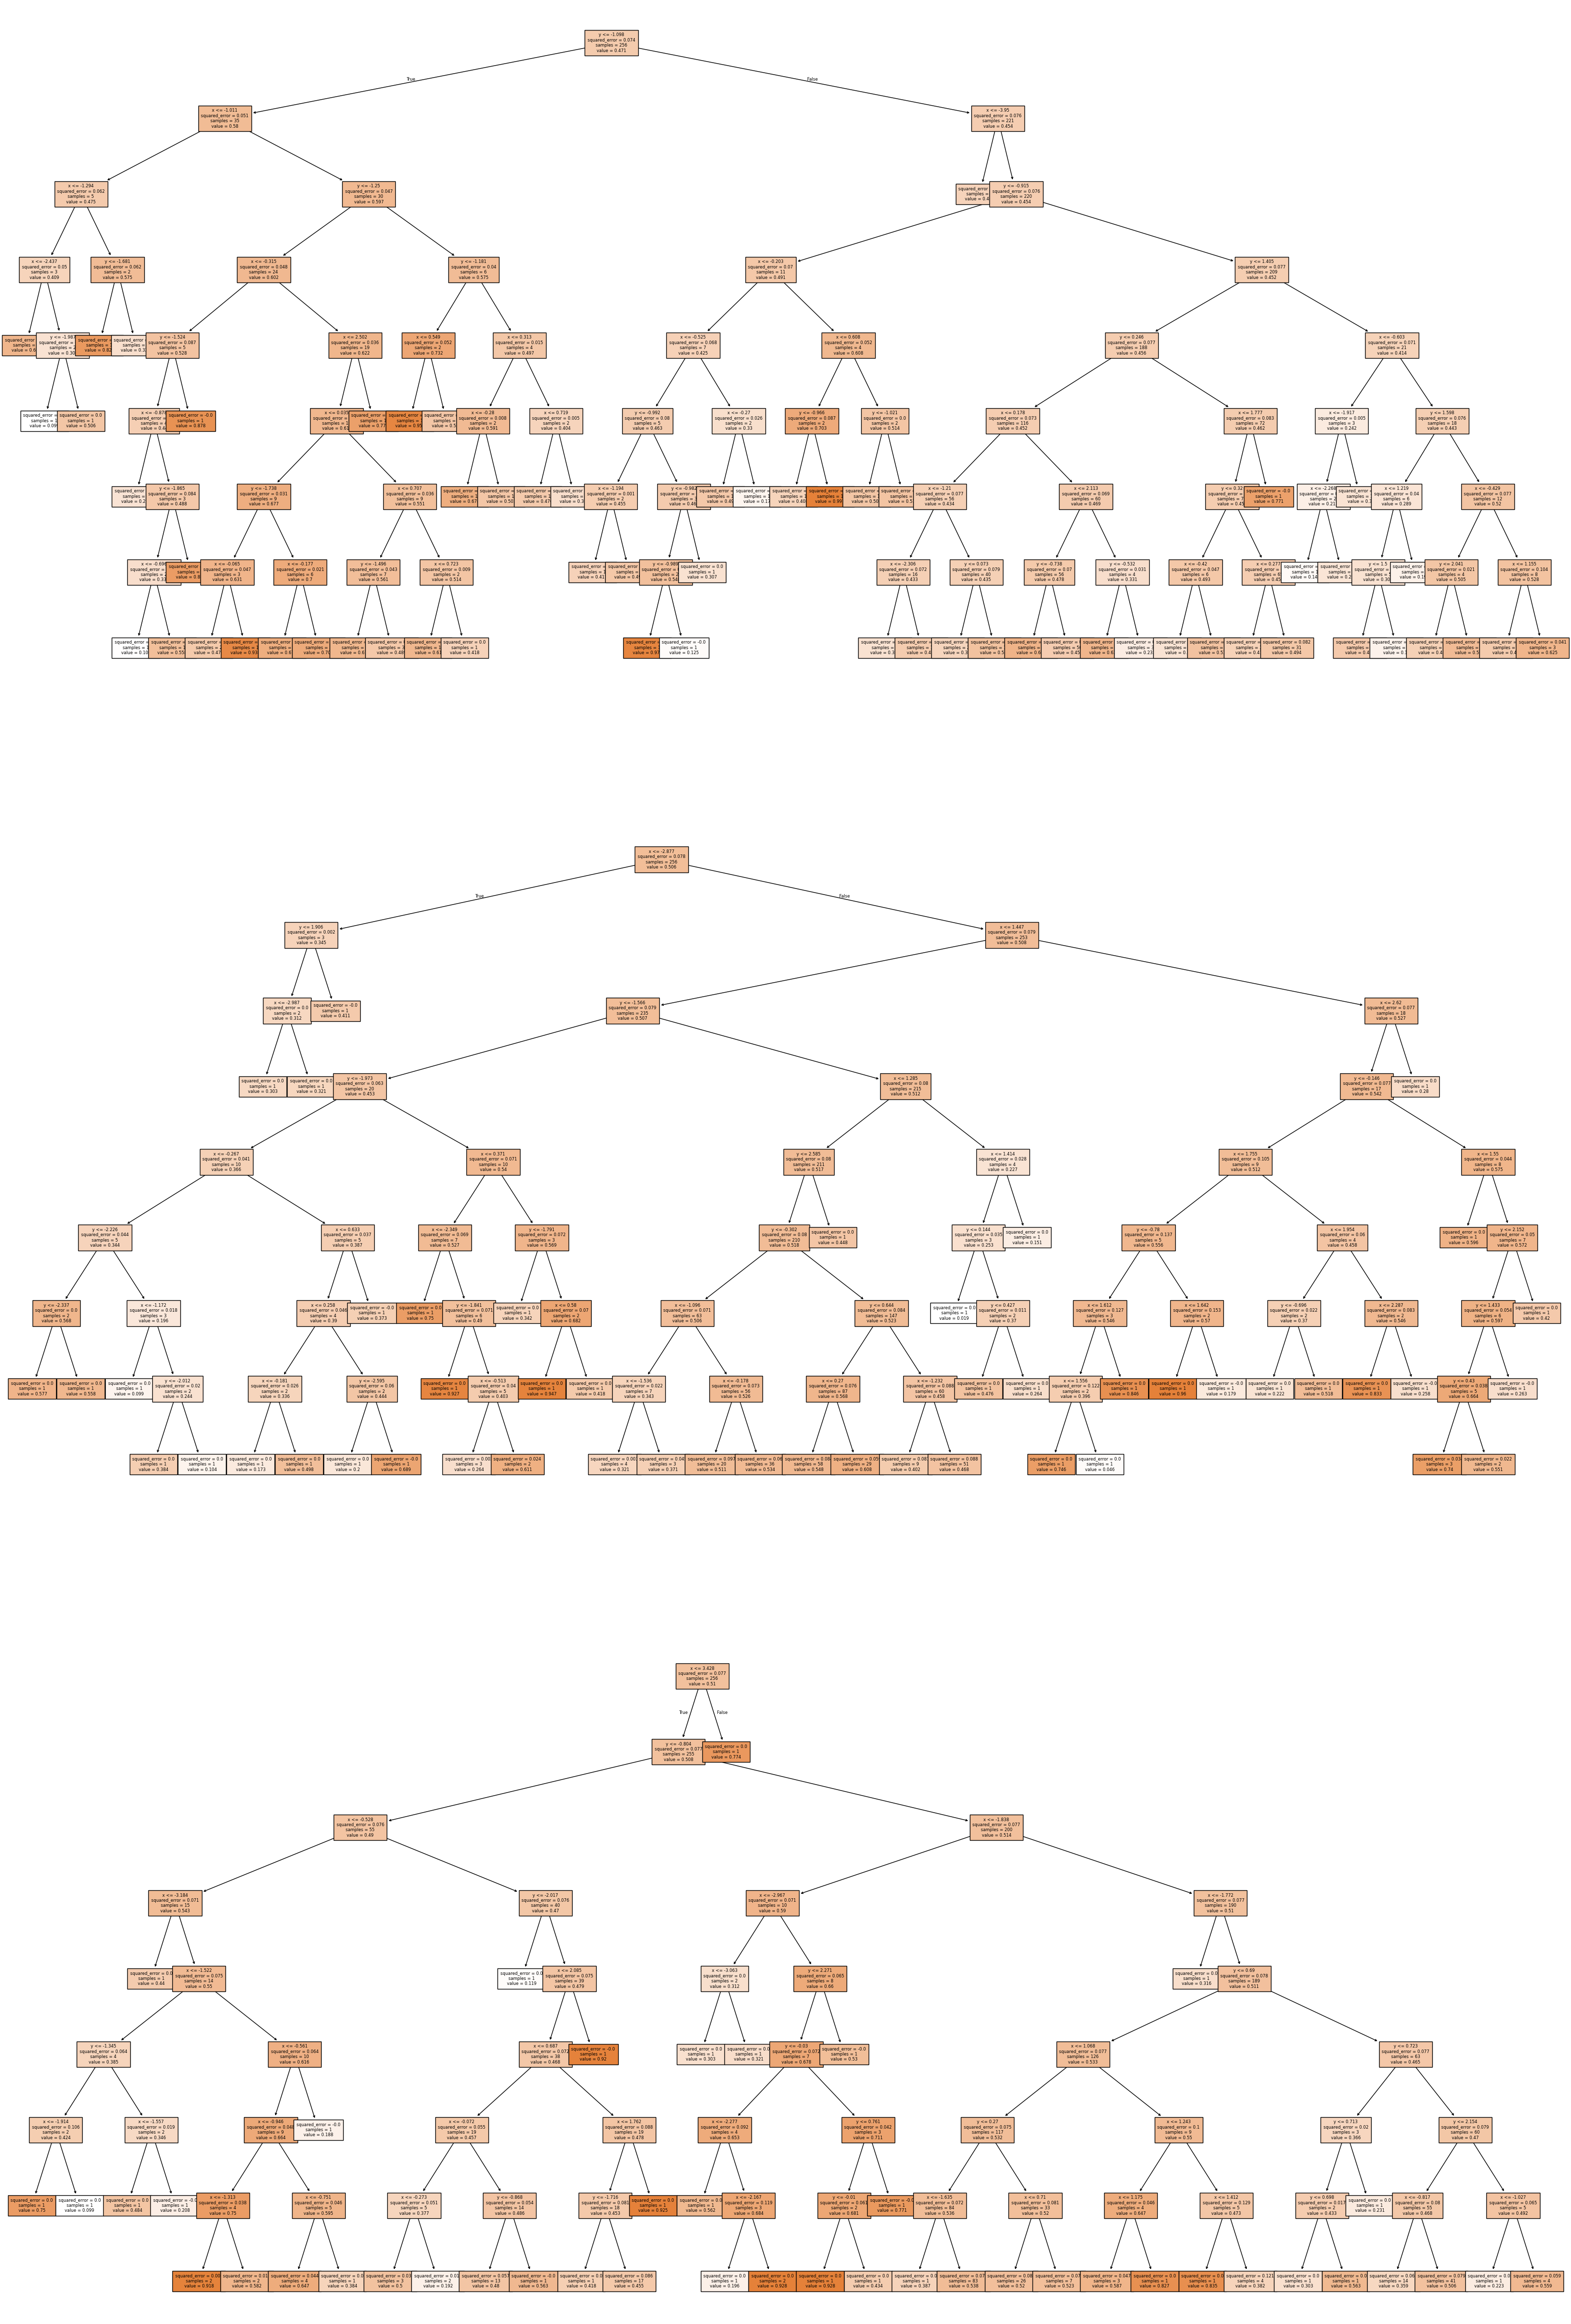

In [36]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(40, 60))
for i in range(3):
    plot_tree(iforest.estimators_[i], ax=ax[i], filled=True, fontsize=6, feature_names=["x","y"])

Metoda Isolation Forest wykorzystuje średnią odległość od korzenia jako miarę anomalii. Możemy wykorzystać tę miarę aby wyświetlić sobie wartość każdego punktu z naszego zbioru na płaszczyźnie. **Im mniejsza będzie to wartość, tym bardziej anormalna jest dana obserwacja.**

In [37]:
anomaly_score = iforest.score_samples(xy_df)

<Axes: xlabel='x', ylabel='y'>

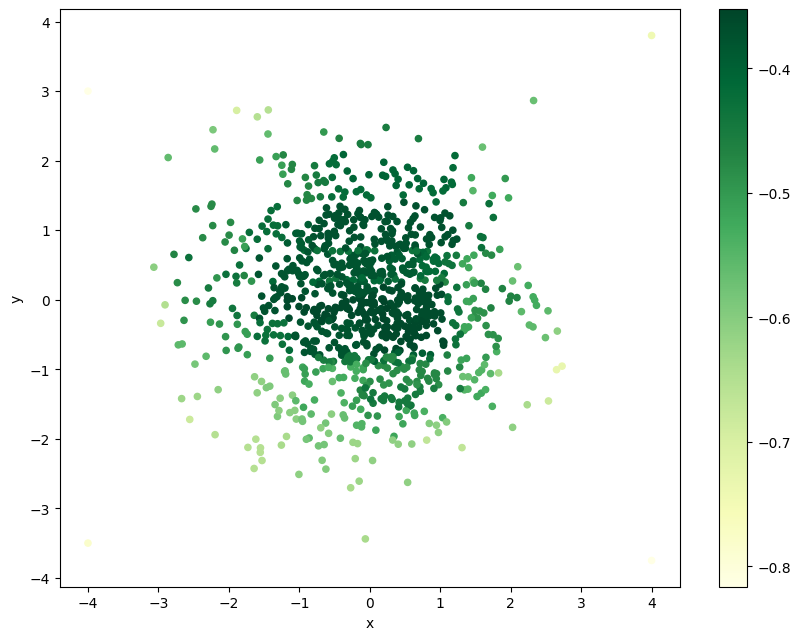

In [40]:
xy_df.plot.scatter(x="x", y="y", c=anomaly_score, cmap="YlGn", figsize=(10, 7.5))